# Stochastic distribution of spatial accessibility to ICU beds during the COVID-19 pandemic in Greater Houston, Texas

### Jinwoo Park <sup>1</sup> and Daniel W. Goldberg <sup>1, 2</sup>
### <sup>1</sup> Department of Geography, Texas A&M University, College Station, Texas, USA
### <sup>2</sup> Department of Computer Science & Engineering, Texas A&M University, College Station, Texas, USA

### Summary

The accessibility and availability of intensive care unit (ICU) beds are particularly critical in the context of COVID-19 because they are closely related to the fatality rate of the disease (Kang et al. 2020). As the spread of COVID-19 gets severe, many hospitals suffer the shortage of their Intensive Care Unit (ICU) beds capacity (Chiwaya and Siemaszko 2020, Walters et al. 2020), and it deteriorates the sufficient access to health care facilities. However, the conventional spatial accessibility measurements utilized deterministic variables as their inputs (i.e., supply, demand, and mobility) (Luo and Wang 2003, Luo and Whippo 2012). Given that the use of static variables assumes full capacity of supply (e.g., all ICU beds are always available) and no interference of mobility (e.g., traffic congestion or unexpected delay), the accessibility to healthcare resources may be overestimated. To address the issue, our study measured spatial accessibility to ICU beds in the Greater Houston area with the two-step floating catchment area (2SFCA) method. We incorporated the uncertainty of supply (i.e., availability of ICU beds) and time-variant mobility into the measurement to obtain the stochastic distribution of accessibility. To be specific, we populated the uncertainty in both data from their historical fluctuations (i.e., supply: https://www.setrac.org; mobility: https://traffic.houstontranstar.org) and ran a Monte-Carlo simulation to measure spatial accessibility from the stochastic perspective. As a result, the spatial accessibility to ICU beds substantially changed throughout the simulation due to the uncertainty in the inputs. In detail, the robustness of accessibility was tied with the number of alternative supplies. Downtown, where numerous hospitals were located, provided high accessibility with high reliability, whereas rural areas with limited health care facilities had low and unreliable accessibility. Interestingly, the counties with insufficient and unreliable accessibility had a higher case-fatality ratio of COVID-19, but the counties with sufficient and reliable accessibility had a lower case-fatality ratio. Therefore, it is revealed that the disparity of the case-fatality ratio of COVID-19 could be attributed to whether locations have sufficient and reliable accessibility. 

### Reference
Chiwaya, N. and Siemaszko, C., 2020. Florida hospitals face ICU bed shortage as state passes 300,000 COVID-19 cases. NBC News, 15 Jul.
Kang, J.Y., Michels, A., Lyu, F., Wang, S., Agbodo, N., Freeman, V.L., and Wang, S., 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International journal of health geographics, 19 (1), 36.
Luo, W. and Wang, F., 2003. Measures of spatial accessibility to health care in a GIS environment: Synthesis and a case study in the Chicago region. Environment and Planning B: Planning and Design, 30 (6), 865–884.
Luo, W. and Whippo, T., 2012. Variable catchment sizes for the two-step floating catchment area (2SFCA) method. Health and Place, 18 (4), 789–795.
Walters, E., Najmabadi, S., and Platoff, E., 2020. Texas hospitals are running out of drugs, beds, ventilators and even staff | The Texas Tribune. The Texas Tribune, 14 Jul.


In [ ]:
try:
    from cybergis_compute_client import CyberGISCompute
    
except:
    import sys
    !{sys.executable} -m pip install jenksp

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import pathlib
import warnings
import jenkspy
import utils
import time
import multiprocessing as mp
import itertools
import matplotlib.patheffects as pe
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
import zipfile
warnings.filterwarnings('ignore')
tqdm.pandas()

# Define paths

In [2]:
# Extract files related to inputs
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
# Extract precalculated results 
with zipfile.ZipFile('./result.zip', 'r') as zip_ref:
    zip_ref.extractall('./result')
    
data_path = pathlib.Path('./data')
csv_path = data_path.joinpath('traffic_data', 'modified_csv')
shp_path = data_path.joinpath('traffic_data', 'shp')
result_path = pathlib.Path('./result')
PROCESSOR_NUM = 6

# 0. Problem statement
## 0.1. Uncertainty in supply (ICU beds) availability
During the second COVID-19 outbreak in Texas (from May 1 to September 30, 2020), the percentage of available ICU beds in Harris County was maximized (21.3%, 344 of 1614 operational ICU beds) on May 25, 2020, and minimized (1.4%, 24 available beds) on July 15. The availability of ICU beds is closely related to the degree of supply that hospitals provide, and there is temporal uncertainty. For instance, an increase in ICU beds availability would alleviate local competition (i.e., more resources and high supply-to-demand ratio), whereas a decrease in availability would worsen it (i.e., fewer resources; low supply-to-demand ratio). 

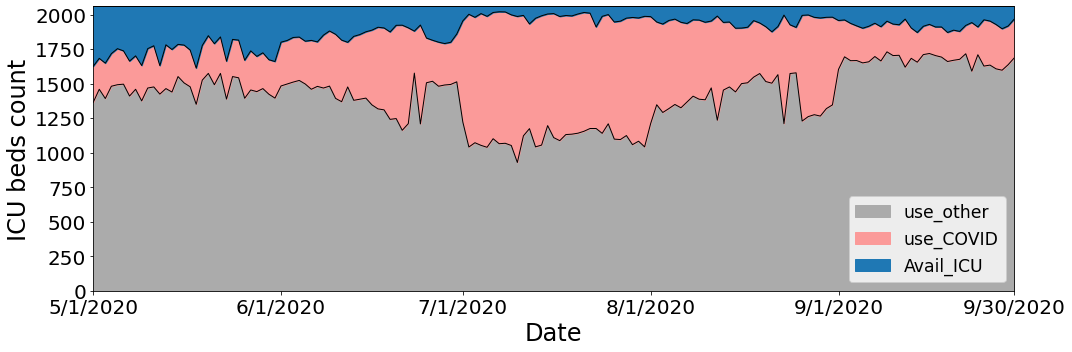

In [3]:
county_list = ['Harris', 'Fort Bend', 'Montgomery', 'Brazoria', 'Galveston', 'Liberty', 'Waller', 'Chambers', 'Austin']
staff_ICU = {'Harris': 1614, 'Fort Bend': 122, 'Montgomery': 174, 'Brazoria': 40, 
           'Galveston': 94, 'Liberty': 8, 'Waller': 0, 'Chambers': 1, 'Austin': 6}
xls_file = pd.read_csv(data_path.joinpath('hospital_availability.csv'))

ICU_usage = xls_file.groupby('Date').sum()
ICU_usage['use_other'] = ICU_usage.apply(lambda x:sum(staff_ICU.values()) - (x['Avail_ICU'] + x['COV_S_ICU'] + x['COV_C_ICU']), axis=1)
ICU_usage['use_COVID'] = ICU_usage.apply(lambda x: (x['COV_S_ICU'] + x['COV_C_ICU']), axis=1)
ICU_usage = ICU_usage.filter(items=['use_other', 'use_COVID', 'Avail_ICU'])

aval_fig = ICU_usage.plot.area(color=['#ABABAB','#fb9a99', '#1f78b4'], linewidth=1, figsize=(15, 5))
for temp_line in aval_fig.lines:
    temp_line.set_color('black')

aval_fig.set_ylim(0, sum(staff_ICU.values()))
aval_fig.set_xlim(0, 152)
aval_fig.set_ylabel('ICU beds count', fontsize=24)
aval_fig.set_xlabel('Date', fontsize=24)
plt.xticks([0, 31, 61, 92, 123, 152], ['5/1/2020', '6/1/2020', '7/1/2020', '8/1/2020', '9/1/2020', '9/30/2020'], fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='lower right', fontsize='xx-large')
plt.tight_layout()

plt.show()

In [4]:
# Missing histrorical usage data for Liberty and Austin counties (No Hospital in Waller county)
# Therefore, we use the usage distribution of other counties to estimate theirs.
aval_ratio = pd.DataFrame(index=xls_file['Date'].unique(), columns=[f'{county}' for county in county_list])

for county in county_list:
    if county in ['Harris', 'Fort Bend', 'Montgomery', 'Brazoria', 'Galveston', 'Chambers']:  
        county_xls = xls_file.loc[xls_file['County'] == county]
        county_xls = county_xls.set_index('Date')
        county_xls['aval_ratio'] = county_xls.apply(lambda x: round((x['COV_S_ICU'] + x['COV_C_ICU'] + x['Avail_ICU']) / staff_ICU[county] * 100, 0), axis=1)
        county_xls = county_xls.filter(items=['use_other', 'use_COVID', 'aval_ratio'])
        
        aval_ratio[county] = county_xls['aval_ratio']
        
    elif county in ['Liberty', 'Austin']: # ICU availability data missing in Liberty and Austin county
        counties_xls = xls_file.groupby('Date').sum()
        counties_xls['aval_ratio'] = counties_xls.apply(lambda x: round((x['COV_S_ICU'] + x['COV_C_ICU'] + x['Avail_ICU']) / sum(staff_ICU.values()) * 100, 0), axis=1)
        aval_ratio[county] = counties_xls['aval_ratio']
        
    else: # No hospital in Waller County
        aval_ratio[county] = 0
        
aval_ratio

,Harris,Fort Bend,Montgomery,Brazoria,Galveston,Liberty,Waller,Chambers,Austin
5/1/2020,33.0,49.0,27.0,38.0,43.0,34.0,0,0.0,34.0
5/2/2020,29.0,43.0,30.0,42.0,39.0,31.0,0,0.0,31.0
5/3/2020,31.0,54.0,38.0,42.0,27.0,33.0,0,0.0,33.0
5/4/2020,32.0,47.0,36.0,8.0,27.0,32.0,0,0.0,32.0
5/5/2020,28.0,48.0,32.0,10.0,46.0,29.0,0,0.0,29.0
...,...,...,...,...,...,...,...,...,...
9/26/2020,17.0,32.0,31.0,32.0,18.0,19.0,0,0.0,19.0
9/27/2020,17.0,33.0,29.0,32.0,18.0,19.0,0,0.0,19.0
9/28/2020,18.0,22.0,24.0,30.0,19.0,19.0,0,0.0,19.0
9/29/2020,15.0,23.0,20.0,22.0,26.0,17.0,0,0.0,17.0


## 0.2. Uncertainty in mobility (travel speed)
In addition, the uncertainty of mobility would change the size and shape of the service area that a facility provides. For example, high mobility during the nighttime would expand the service area of supply, whereas low mobility during the daytime would shrink it.

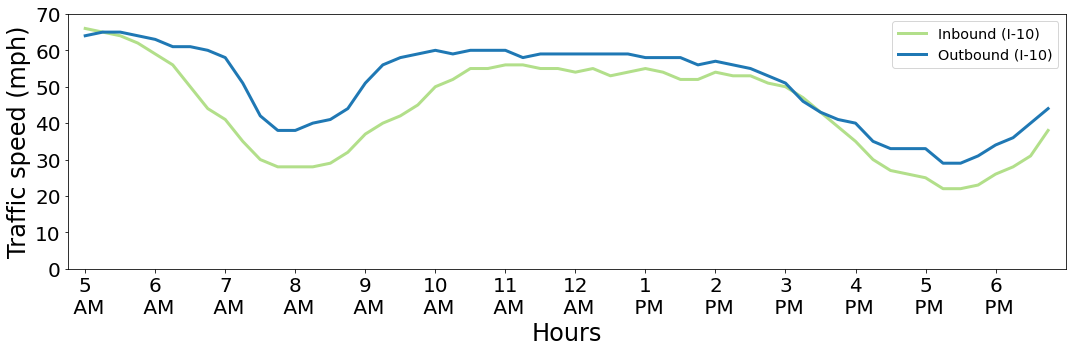

In [5]:
inbound = pd.read_csv(csv_path.joinpath('IH10K_Beltway8_Downtown.csv'))
inbound = inbound.set_index('Departure')
outbound = pd.read_csv(csv_path.joinpath('IH10K_Downtown_Beltway8.csv'))
outbound = outbound.set_index('Departure')

mobility = pd.DataFrame(index=inbound.index)
mobility['inbound'] = inbound['Average']
mobility['outbound'] = outbound['Average']
mobility

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
plt.plot(mobility.index, mobility['inbound'], label='Inbound (I-10)', color='#b2df8a', linewidth=3)
plt.plot(mobility.index, mobility['outbound'], label='Outbound (I-10)', color='#1f78b4', linewidth=3)
plt.xticks(list(range(0, 55, 4)), [f'{h}\n AM' for h in range(5, 13, 1)] + [f'{h}\n PM' for h in range(1, 7, 1)], fontsize=20)
plt.yticks(fontsize=20)
ax1.set_ylabel('Traffic speed (mph)', fontsize=24)
ax1.set_xlabel('Hours', fontsize=24)
ax1.set_xlim(-1, 56)
ax1.set_ylim(0, 70)
plt.legend(loc='upper right', fontsize='x-large')
plt.tight_layout()

## 0.3. Study Area: the Greater Houston, Texas

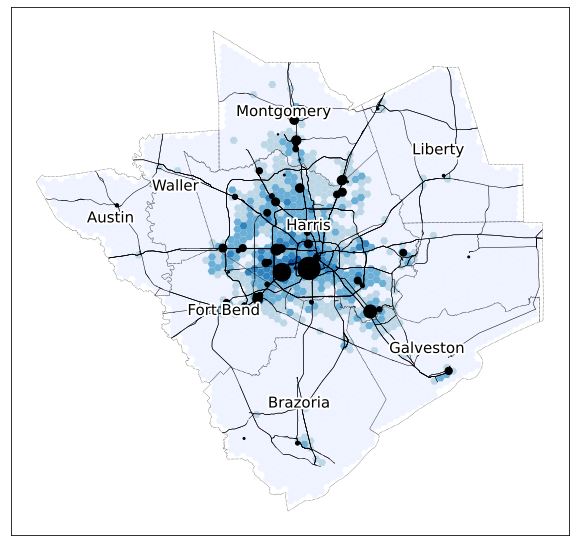

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

supply = gpd.read_file(data_path.joinpath('geocoded_hospital.shp'))
supply = supply.set_index('SupplyID')
supply = supply.loc[supply['ADULT_ICU_'] != 0]

demand = gpd.read_file(data_path.joinpath('hexagon_houston_pop.shp'))
demand = demand.set_index('GRID_ID')

boundary = gpd.read_file(data_path.joinpath('county_houston.shp'))
boundary = boundary.set_index('NAME')
road = gpd.read_file(data_path.joinpath('major_roads.shp'))

colorBrewer = ['#eff3ff', '#bdd7e7', '#6baed6', '#3182bd', '#08519c']
breaks = jenkspy.jenks_breaks(demand.Pop, nb_class=5)
for idx, cls in enumerate(breaks):
    if idx == 0:  
        continue

    temp_hxg = demand.loc[(breaks[idx-1] <= demand['Pop']) & (demand['Pop'] <= cls)]
    if temp_hxg.shape[0] > 0:
        temp_hxg.plot(ax=ax, color=colorBrewer[idx-1])

supply.plot(ax=ax, markersize=supply['ADULT_ICU_'] * 2, color='black')
boundary.apply(lambda x:ax.annotate(s=x.NAMELSAD.split('C')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                    fontsize=15, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
road.plot(ax=ax, linewidth=0.5, edgecolor='k')
boundary.boundary.plot(ax=ax, linewidth=0.5, edgecolor='k', linestyle=':')
plt.show()

# 1. Analytical Framework

We used the following three steps to measure spatial accessibility to ICU beds under the temporal uncertainty of supply and mobility. 
1) Calculate the probability distribution of supply and mobility, which would be used as the randomized input variables in the Monte-Carlo simulation. <br>
2) Assess spatial accessibility to ICU beds 999 times (i.e., Monte-Carlo simulation) to investigate the impacts of the two randomized variables on the measures. The simulation provided the stochastic distribution of the measures for each location. <br>
3) Spatial clustering was implemented to group locations based on the measures and to demonstrate which locations had sufficient and reliable accessibility.<br>

<img src='./workflow.jpg' width='800'/>

## 1.1. Calculate probability distribution of supply and mobility

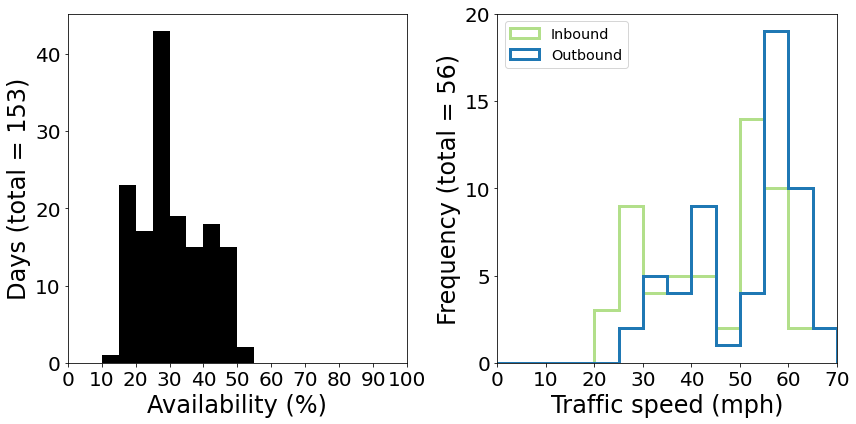

In [7]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 2, 1)

aval_ratio['Harris'].hist(bins=[10, 15, 20, 25, 30, 35, 40, 45, 50, 55], ax=ax1, color='black', grid=False)
plt.xticks(list(range(0, 105, 10)), fontsize=20)
plt.yticks(fontsize=20)
ax1.set_ylabel('Days (total = 153)', fontsize=24)
ax1.set_xlabel('Availability (%)', fontsize=24)
ax1.set_xlim(0, 100)

ax2 = fig.add_subplot(1, 2, 2)
plt.hist(mobility['inbound'], bins=list(range(0, 75, 5)), label='Inbound', edgecolor='#b2df8a', linewidth=3, histtype='step')
plt.hist(mobility['outbound'], bins=list(range(0, 75, 5)), label='Outbound' , edgecolor='#1f78b4', linewidth=3, histtype='step')
plt.legend(loc='upper left', fontsize='x-large')
ax2.set_ylabel('Frequency (total = 56)', fontsize=24)
ax2.set_xlabel('Traffic speed (mph)', fontsize=24)
ax2.set_xlim(0, 70)
plt.xticks(fontsize=20)
plt.yticks([0, 5, 10, 15, 20],fontsize=20)

plt.tight_layout()

In [8]:
# Calculate the percentage of how many percentage of ICU beds are available
probs = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

supply_prob = pd.DataFrame(index=county_list, columns=probs)
for county in county_list:
    for idx, val in enumerate(probs):
        if idx == len(probs) - 1:
            break
            
        supply_prob.loc[county, probs[idx+1]] = aval_ratio.loc[(aval_ratio[county] >= val*100) & (aval_ratio[county] < probs[idx +1]*100)].shape[0]
    
supply_prob = supply_prob / 153
supply_prob = supply_prob.drop(columns=[0.0])

for county in ['Liberty', 'Austin']:
    for col in [0.2, 0.4, 0.6, 0.8, 1.0]:
        supply_prob.loc[county, col] = supply_prob.loc[['Harris', 'Fort Bend', 'Montgomery', 
                                                        'Brazoria', 'Galveston', 'Chambers'], col].mean(axis=0)

for col in supply_prob.columns:
    supply_prob[col] = supply_prob[col].astype(float)

supply_prob = supply_prob.round(decimals=3)  
for idx in supply_prob.index:
    sum_prob = round(supply_prob.loc[idx].sum(), 3)
    if sum_prob < 1:
        supply_prob.loc[idx, 1.0] += 1 - sum_prob
        
    elif sum_prob > 1:
        supply_prob.loc[idx, 0.2] -= sum_prob - 1

supply_prob

,0.2,0.4,0.6,0.8,1.0
Harris,0.157,0.614,0.229,0.000,0.000
Fort Bend,0.052,0.301,0.490,0.150,0.007
Montgomery,0.144,0.673,0.176,0.007,0.000
Brazoria,0.098,0.477,0.340,0.085,0.000
Galveston,0.046,0.412,0.359,0.170,0.013
Liberty,0.246,0.413,0.266,0.069,0.006
Waller,1.000,0.000,0.000,0.000,0.000
Chambers,0.980,0.000,0.000,0.000,0.020
Austin,0.246,0.413,0.266,0.069,0.006


## 1.2. Monte-Carlo simulation of spatial accessibility measurements

In [9]:
# Import mobility-related files
file_names = pd.read_csv(data_path.joinpath('traffic_data', 'file_names.txt'), header=None)
original_nodes = gpd.read_file(data_path.joinpath('osm_network_greater_houston', 'nodes.shp'))
merged_edge = utils.road_network_with_uncertainty(file_names, data_path)
G = utils.construct_network(merged_edge, original_nodes)
G = utils.remove_uncenessary_nodes(G)

# Find nearest node of OSM from supply and demand locations
supply = utils.find_nearest_osm(G, supply)
# demand = utils.find_nearest_osm(G, demand)

{'disused', 'razed', "['road', 'residential']", 'road', 'toll_gantry'}


100%|███████████████████████████████████████████████████████████████████████| 262552/262552 [00:22<00:00, 11454.06it/s]


Removed 644 nodes (0.0025%) from the OSMNX network
Number of nodes: 261908


  0%|                                                                                           | 0/83 [00:00<?, ?it/s]

Number of edges: 637266


100%|██████████████████████████████████████████████████████████████████████████████| 2857/2857 [11:25<00:00,  4.17it/s]


In [10]:
# Set threshold travel time and corresponding spatial impedance
minutes = [10, 20, 30]
weights = {10: 1, 20: 0.68, 30: 0.22}

start = int(time.time())
pool = mp.Pool(processes = PROCESSOR_NUM)
access_result = pool.map(utils.measure_accessibility_unpacker,
                         zip(range(PROCESSOR_NUM),
                             itertools.repeat(supply),
                             itertools.repeat(demand),
                             itertools.repeat(supply_prob),
                             itertools.repeat(file_names),
                             itertools.repeat(original_nodes),
                             itertools.repeat(minutes),
                             itertools.repeat(weights),
                             itertools.repeat(data_path),
                             itertools.repeat(result_path)
                            )
                        )
end = int(time.time())
pool.close()
print("***run time(min) : ", (end-start)/60)

***run time(min) :  52.916666666666664


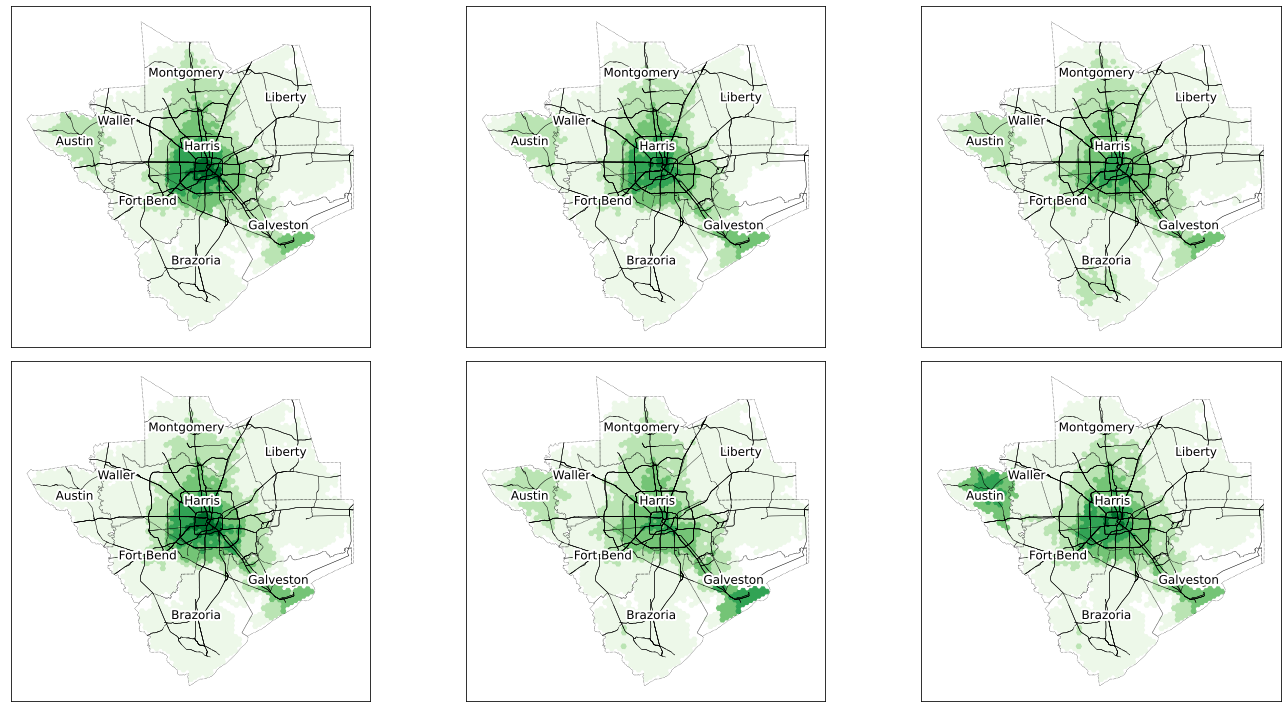

In [24]:
plt_cls = [0, 5, 10, 15, 20, 25]
colors = ['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c']

fig = plt.figure(figsize=(20, 10))
for i in range(PROCESSOR_NUM):
    ax = fig.add_subplot(2, 3, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    temp_result = gpd.read_file(result_path.joinpath (f'iter_{i}', 'demand.geojson'))
    
    for idx, cls in enumerate(plt_cls):
        if idx == 0: continue
        temp_cls = temp_result.loc[(plt_cls[idx-1] < temp_result[f'step2']) & (temp_result[f'step2'] <= cls)]
        if temp_cls.shape[0] > 0:
            temp_cls.plot(ax=ax, color=colors[idx-1], edgecolor=colors[idx-1])
            
    boundary.apply(lambda x:ax.annotate(s=x.NAMELSAD.split('C')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                    fontsize=12, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
    
    road.plot(ax=ax, linewidth=0.5, edgecolor='k')
    boundary.boundary.plot(ax=ax, linewidth=0.5, edgecolor='k', linestyle=':')
            
plt.tight_layout()
plt.show()

## 1.3. Spatial clustering

In [12]:
measures = gpd.read_file(result_path.joinpath(r'precalculated_measures.shp'))
measures = measures.loc[measures['Note'] != 'water']
measures = measures.fillna(0)
measures = measures.set_index('GRID_ID')
measures.head()

,OBJECTID_1,Note,Shape_Leng,Shape_Area,Pop,n_0,n_1,n_2,n_3,n_4,...,p05,p25,p50,p75,p95,cqv,mean,std,cv,geometry
GRID_ID,,,,,,,,,,,,,,,,,,,,,
AR-66,2,no_node,10590.960394,8.095060e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"POLYGON ((-95.46480 28.83302, -95.47431 28.819..."
AP-65,6,0,10590.960740,8.095061e+06,0.0,0.450437,0.490869,0.170959,0.392004,0.531646,...,0.636874,0.511784,0.409211,0.349155,0.177348,0.188898,0.425247,0.124280,0.292254,"POLYGON ((-95.51810 28.86203, -95.52761 28.848..."
AR-65,7,no_node,10590.960740,8.095061e+06,0.0,0.393478,0.637447,0.170959,0.343231,0.531646,...,0.660915,0.524689,0.418019,0.351010,0.214888,0.198332,0.437549,0.131111,0.299649,"POLYGON ((-95.46385 28.86060, -95.47336 28.847..."
AS-65,8,no_node,10590.960340,8.095060e+06,0.0,0.393478,0.637447,0.170959,0.343231,0.531646,...,0.660915,0.524689,0.418019,0.351010,0.214888,0.198332,0.437549,0.131111,0.299649,"POLYGON ((-95.43720 28.84609, -95.44672 28.832..."
AT-65,9,no_node,10590.960740,8.095061e+06,0.0,0.393478,0.637447,0.170959,0.343231,0.531646,...,0.660915,0.524689,0.418019,0.351010,0.214888,0.198332,0.437549,0.131111,0.299649,"POLYGON ((-95.40959 28.85914, -95.41912 28.845..."


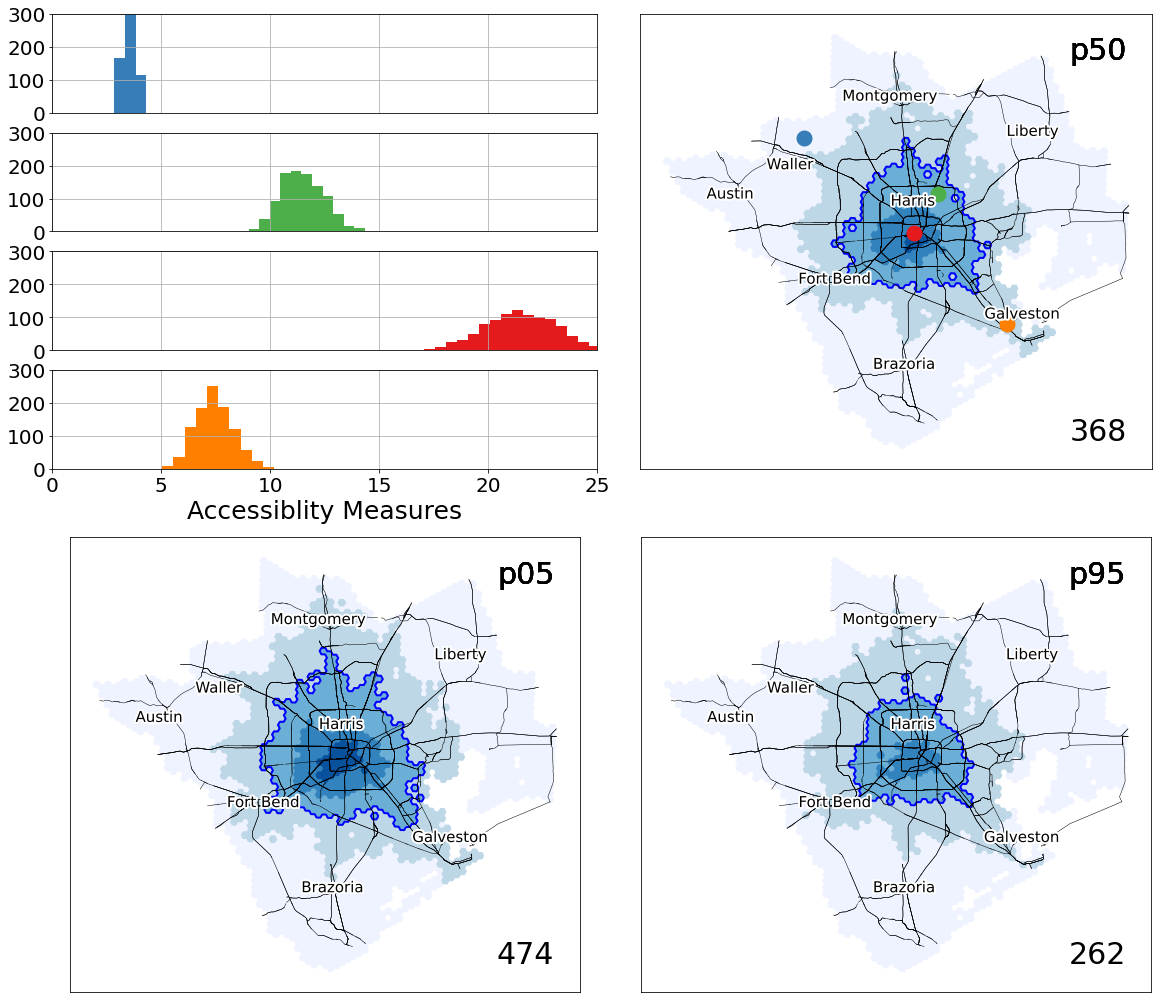

In [13]:
colors = ['#eff3ff', '#bdd7e7', '#6baed6', '#3182bd', '#08519c']
plt_cls = [0, 5, 10, 15, 20, 25]
good_acc_value = 10
hxg_plot = ['Z-19','AX-27', 'AT-33', 'BK-46']
hxg_colors = ['#377eb8', '#4daf4a', '#e41a1c', '#ff7f00']

fig = plt.figure(figsize=(20, 18))
outer = gridspec.GridSpec(2, 2, wspace=0.05, hspace=0.15)
for idx, ratio in enumerate(['p50', 'p05', 'p95']):
    ax = plt.Subplot(fig, outer[idx+1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for idx, cls in enumerate(plt_cls):
        if idx == 0: continue
        temp_hxg = measures.loc[(plt_cls[idx-1] < measures[f'{ratio}']) & (measures[f'{ratio}'] <= cls)]
        if temp_hxg.shape[0] > 0:
            temp_hxg.plot(ax=ax, color=colors[idx-1], edgecolor=colors[idx-1])
        ax.text(0.95, 0.95, str(ratio), fontsize=30, ha='right', va='top', transform=ax.transAxes)
    
    good_acc = measures.loc[measures[f'{ratio}'] >= good_acc_value]
    good_acc['dummy'] = 'dummy'
    good_acc.dissolve(by='dummy').boundary.plot(ax=ax, color=None, edgecolor='blue', linewidth=2)
    ax.text(0.95, 0.05, str(good_acc.shape[0]), fontsize=30, ha='right', va='bottom', transform=ax.transAxes)
    
    # supplementary poi
    boundary.apply(lambda x:ax.annotate(s=x.NAMELSAD.split('C')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                        fontsize=15, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
    road.plot(ax=ax, linewidth=0.5, edgecolor='k')
    fig.add_subplot(ax)
    
    if ratio == 'p50':
        for idx_2, hxg in enumerate(hxg_plot):
            measures.loc[measures.index == hxg].plot(color=hxg_colors[idx_2], ax=ax)
            measures.loc[measures.index == hxg].centroid.plot(color=hxg_colors[idx_2], ax=ax, linewidth=10, zorder=2)
                
        inner = gridspec.GridSpecFromSubplotSpec(4, 1,
                subplot_spec=outer[0], wspace=0.1, hspace=0.2)
        # Histogram
        for idx_1, hxg in enumerate(hxg_plot):
            ax1 = plt.Subplot(fig, inner[idx_1])
            temp_df = measures.loc[hxg, [f'n_{num}' for num in range(1000)]]
            bins = round((temp_df.max() - temp_df.min()) / 0.5)
            temp_df.hist(ax=ax1, color=hxg_colors[idx_1], bins=bins)

            ax1.set_xlim(0, 25)
            ax1.set_ylim(0, 300)
            ax1.set_yticks([0, 100, 200, 300])
            ax1.tick_params(axis='both', labelsize=20)
            ax1.grid(True)
            
            if idx_1 != 3:
                plt.setp(ax1.get_xticklabels(), visible=False)
                ax1.tick_params(axis='x', which='both', length=0)
            else:
                ax1.set_xticks([0, 5, 10, 15, 20, 25])
                ax1.set_xlabel('Accessiblity Measures', fontsize=25)
            fig.add_subplot(ax1)
    else:
        pass
    
plt.tight_layout()
plt.show()

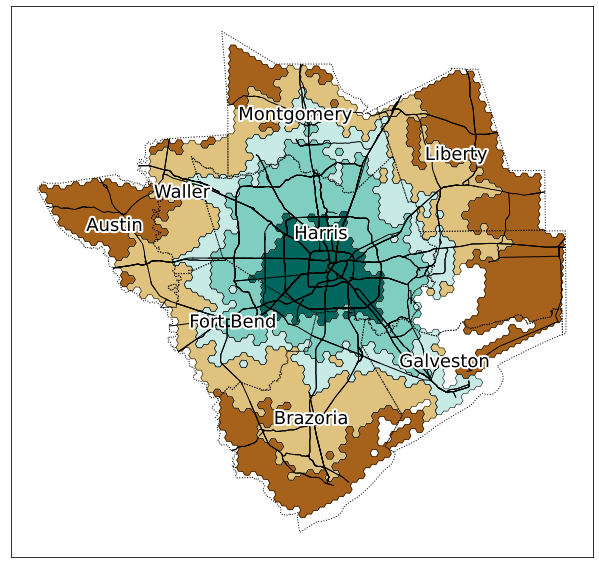

In [27]:
color_list = ['#01665e', '#80cdc1', '#a6611a', '#dfc27d', '#c7eae5']

m_acc = measures[[f'n_{i}' for i in range(1000)]]  # Only columns of values
m_acc = m_acc.fillna(0)

clustering = AgglomerativeClustering(n_clusters = 5, linkage='ward').fit(m_acc)
measures['cluster'] = clustering.labels_

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
for i in range(5):    
    tt = measures.loc[measures['cluster'] == i]
    tt.plot(ax=ax, color=color_list[i], edgecolor=color_list[i])
    tt.dissolve('cluster').boundary.plot(color='black', ax=ax, linewidth=0.5)
        
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# supplementary poi
boundary.apply(lambda x:ax.annotate(s=x.NAMELSAD.split('C')[0], xy=x.geometry.centroid.coords[0], ha='center', 
                                    fontsize=18, path_effects=[pe.withStroke(linewidth=4, foreground="white")]), axis=1)
road.plot(ax=ax, linewidth=1, edgecolor='k')
boundary.boundary.plot(ax=ax, linewidth=1, edgecolor='k', linestyle=':')
plt.tight_layout()
plt.show()

# 2. Relationship between accessibility and case-fatality ratio
We observed a trend where the case fatality ratio of COVID-19 can be attributed to unsatisfactory accessibility even though it may not be statistically significant because of the limited number of samples (n = 9 counties). Three of nine counties showed a higher case fatality rate than the average in the study area. While 18‰ (18 fatalities per 1,000 people) of the case fatality rate was observed as of September 30, 2020, Liberty, Austin, and Harris counties had case fatality rates of 23‰, 20‰, and 19‰, respectively. Liberty and Austin counties had insufficient (mean accessibility: 2.09 and 1.64) and unreliable (mean CV of accessibility: 0.13 and 0.27) accessibility. Therefore, their high rates can be related to the attributes of their accessibility. However, Harris County had a robust accessibility (mean accessibility: 10.39, and mean CV: 0.07). Its casualty could be caused by the intensive transmission of the virus within a short period, which was often reported in a high-density city such as New York.

In [28]:
# Calculate case-fatality ratio of each county until September 30, 2020.
case = pd.read_excel(data_path.joinpath('covid_case.xlsx'), header=2, index_col='County Name')
case_texas = case.loc['Total','Cases 09-30-2020']
case_study_area = case.loc[['Harris', 'Fort Bend', 'Montgomery', 'Brazoria', 'Galveston', 'Liberty', 'Waller', 'Chambers', 'Austin'], 'Cases 09-30-2020']
case_study_area.index = case_study_area.index.str.lower()

death = pd.read_excel(data_path.joinpath('covid_fatality.xlsx'), header=2, index_col='County Name')
death_texas = death.loc['Total', 'Fatalities 09-30-2020']
death_study_area = death.loc[['Harris'.upper(), 'Fort Bend'.upper(), 'Montgomery'.upper(), 'Brazoria'.upper(), 'Galveston'.upper(), 'Liberty'.upper(), 'Waller'.upper(), 'Chambers'.upper(), 'Austin'.upper()], 'Fatalities 09-30-2020']
death_study_area.index = death_study_area.index.str.lower()

death_ratio = pd.DataFrame({'case': case_study_area, 'death': death_study_area})
death_ratio['ratio'] = death_ratio['death'] / death_ratio['case'] * 1000
death_ratio_texas = death_texas / case_texas
death_ratio

,case,death,ratio
County Name,,,
harris,142315.0,2751,19.330359
fort bend,16387.0,299,18.246171
montgomery,10773.0,169,15.687367
brazoria,11440.0,176,15.384615
galveston,11670.0,165,14.138817
liberty,2254.0,54,23.957409
waller,858.0,15,17.482517
chambers,1342.0,8,5.961252
austin,497.0,10,20.120724


In [17]:
# Calculate the mean and coefficient of variance of accessibility to ICU beds per each county
measures.loc[measures['cv'] > 1, 'cv'] = 1

death_ratio['acc_mean'] = 0.0
death_ratio['acc_cv'] = 0.0

for idx, row in boundary.iterrows():
    temp_mean = measures.loc[measures.geometry.intersects(row.geometry),  'mean'].mean()
    temp_cv = measures.loc[measures.geometry.intersects(row.geometry),  'cv'].mean()
    
    county_name = idx.lower()
    
    death_ratio.at[county_name, 'acc_mean'] = temp_mean
    death_ratio.at[county_name, 'acc_cv'] = temp_cv
    
death_ratio

,case,death,ratio,acc_mean,acc_cv
County Name,,,,,
harris,142315.0,2751,19.330359,10.387796,0.068612
fort bend,16387.0,299,18.246171,6.687958,0.078936
montgomery,10773.0,169,15.687367,4.908958,0.083916
brazoria,11440.0,176,15.384615,3.448103,0.162890
galveston,11670.0,165,14.138817,4.699436,0.195213
liberty,2254.0,54,23.957409,2.086059,0.131802
waller,858.0,15,17.482517,3.557891,0.094859
chambers,1342.0,8,5.961252,2.076195,0.222773
austin,497.0,10,20.120724,1.637875,0.270804


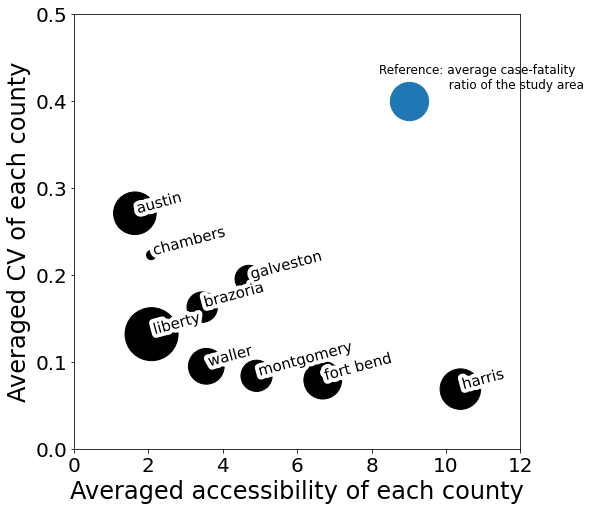

In [18]:
study_area_ratio = death_ratio.death.sum()/death_ratio.case.sum()*1000

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.scatter(death_ratio.acc_mean, death_ratio.acc_cv, death_ratio.ratio**2.5, color='black')
ax.scatter(9, 0.4, study_area_ratio**2.5)  # total case-fatality ratio of the study area
ax.text(x=8.2, y=0.415,  s='Reference: average case-fatality \n                  ratio of the study area', fontsize=12)

ax.set_xlim(xmin=0, xmax=12)
ax.set_ylim(ymin=0, ymax=0.5)
ax.set_xlabel('Averaged accessibility of each county', fontsize=24)
ax.set_ylabel('Averaged CV of each county', fontsize=24)

for idx, row in death_ratio.iterrows():
    ax.text(x=row['acc_mean'], y=row['acc_cv'], s=idx, rotation=15, fontsize=15, path_effects=[pe.withStroke(linewidth=8, foreground="white")])
